# Per-Decision variance comparison
We want to inspect the differences in variance (by comparing the performances) of vanilla-POIS versus Per-Decision-POIS (PD-POIS).
We start by loading the necessary data from sacred file storage.

In [1]:
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import load_runs, filter_runs, plot_mean_ci, plot_all

First we need to load all the runs from the sacred dataset.

In [2]:
runs = load_runs('../sacred_runs/')
print("Loaded runs:", len(runs.keys()))

Loaded runs: 178


We also create a base query which will be used throughout this notebook:

In [3]:
base_query = {
    'run.status': 'COMPLETED',
    'config.center': True,
    'config.gamma': 0.99,
    'config.clipping': False,
    'config.njobs': 1,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none',
    'run.host.hostname': 'nash'
}

## CartPole with 100 episodes
We start by inspecting the CartPole environment, using 100 episodes for each iteration. First we load all our different runs.

In [4]:
# IS, no entropy
print('--- IS no entropy ---')
cp_is_100_noent_query = {
    'config.entropy': 'none',
    'config.env': 'cartpole',
    'config.iw_method': 'is',
    'config.delta': 0.4,
    'config.bound': 'max-d2',
    'config.num_episodes': 100
}
cp_is_100_noent = filter_runs({**base_query, **cp_is_100_noent_query}, runs)
print("cp_is_100_noent:", len(cp_is_100_noent.keys()))
print("seeds:", ", ".join(map(str, [cp_is_100_noent[key]['config']['seed'] for key in cp_is_100_noent.keys()])))

# IS, basic entropy
print('--- IS with entropy ---')
cp_is_100_ent_query = {
    'config.entropy': 'step:10.0:100',
    'config.env': 'cartpole',
    'config.iw_method': 'is',
    'config.delta': 0.4,
    'config.bound': 'max-d2',
    'config.num_episodes': 100
}
cp_is_100_ent = filter_runs({**base_query, **cp_is_100_ent_query}, runs)
print("cp_is_100_ent:", len(cp_is_100_ent.keys()))
print("seeds:", ", ".join(map(str, [cp_is_100_ent[key]['config']['seed'] for key in cp_is_100_ent.keys()])))

# PDIS, no entropy 
print('--- PDIS no entropy ---')
cp_pdis_100_noent_query = {
    'config.entropy': 'none',
    'config.env': 'cartpole',
    'config.iw_method': 'pdis',
    'config.delta': 0.4,
    'config.bound': 'pdis-d2',
    'config.num_episodes': 100
}
cp_pdis_100_noent = filter_runs({**base_query, **cp_pdis_100_noent_query}, runs)
print("cp_pdis_100_noent:", len(cp_pdis_100_noent.keys()))
print("seeds:", ", ".join(map(str, [cp_pdis_100_noent[key]['config']['seed'] for key in cp_pdis_100_noent.keys()])))


# PDIS, no entropy 
print('--- PDIS with entropy ---')
cp_pdis_100_ent_query = {
    'config.entropy': 'step:10.0:100',
    'config.env': 'cartpole',
    'config.iw_method': 'pdis',
    'config.delta': 0.4,
    'config.bound': 'pdis-d2',
    'config.num_episodes': 100
}
cp_pdis_100_ent = filter_runs({**base_query, **cp_pdis_100_ent_query}, runs)
print("cp_pdis_100_noent:", len(cp_pdis_100_ent.keys()))
print("seeds:", ", ".join(map(str, [cp_pdis_100_ent[key]['config']['seed'] for key in cp_pdis_100_ent.keys()])))

--- IS no entropy ---
cp_is_100_noent: 5
seeds: 160, 109, 570, 904, 10
--- IS with entropy ---
cp_is_100_ent: 5
seeds: 109, 160, 904, 570, 10
--- PDIS no entropy ---
cp_pdis_100_noent: 5
seeds: 10, 109, 160, 904, 570
--- PDIS with entropy ---
cp_pdis_100_noent: 5
seeds: 10, 904, 109, 160, 570


Now that we have loaded all the experiments we need we can show the results.

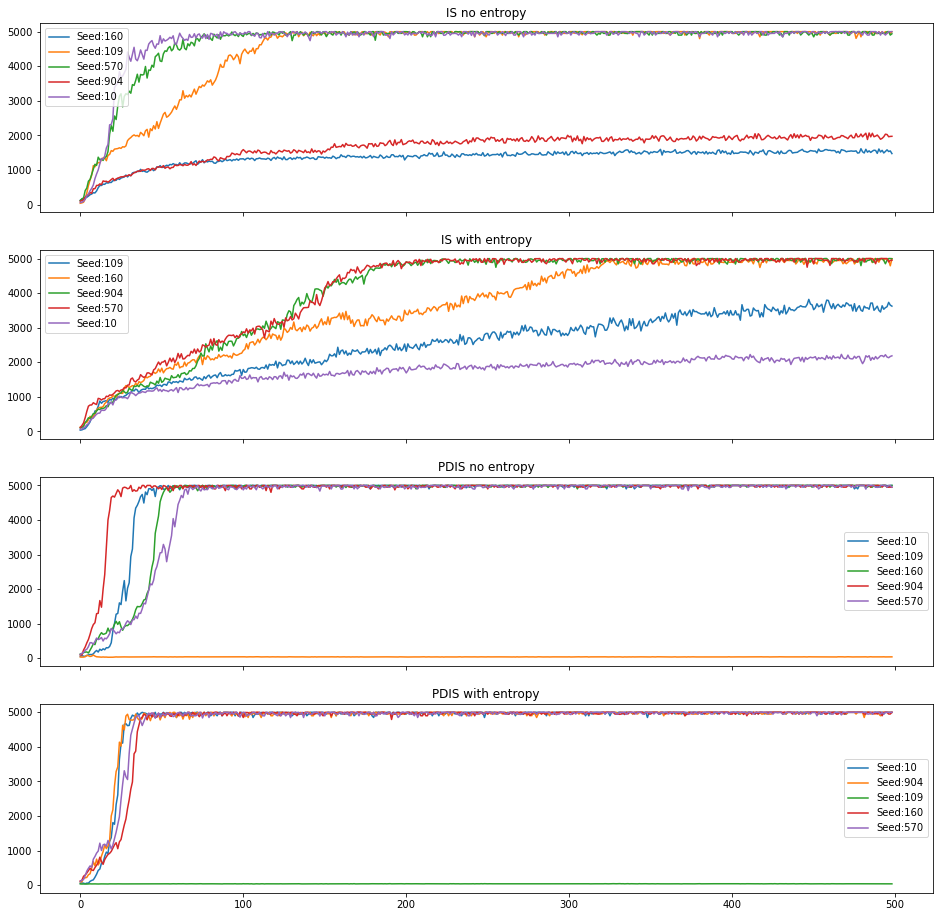

In [5]:
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(16,16), sharex=True, sharey=True)
plot_all(cp_is_100_noent, 'EpRewMean', axis[0])
axis[0].set_title('IS no entropy')
plot_all(cp_is_100_ent, 'EpRewMean', axis[1])
axis[1].set_title('IS with entropy')
plot_all(cp_pdis_100_noent, 'EpRewMean', axis[2])
axis[2].set_title('PDIS no entropy')
plot_all(cp_pdis_100_ent, 'EpRewMean', axis[3])
axis[3].set_title('PDIS with entropy')
plt.show();

## CartPole using 20 episodes
Now we will use only 20 episodes for each iteration. This should increase the variance of each step, so it could show better if the PDIS method has less variance

In [6]:
# IS, no entropy
print('--- IS no entropy ---')
cp_is_20_noent_query = {
    'config.entropy': 'none',
    'config.env': 'cartpole',
    'config.iw_method': 'is',
    'config.delta': 0.4,
    'config.bound': 'max-d2',
    'config.num_episodes': 20
}
cp_is_20_noent = filter_runs({**base_query, **cp_is_20_noent_query}, runs)
print("cp_is_20_noent:", len(cp_is_20_noent.keys()))
print("seeds:", ", ".join(map(str, [cp_is_20_noent[key]['config']['seed'] for key in cp_is_20_noent.keys()])))

# IS, basic entropy
print('--- IS with entropy ---')
cp_is_20_ent_query = {
    'config.entropy': 'step:10.0:100',
    'config.env': 'cartpole',
    'config.iw_method': 'is',
    'config.delta': 0.4,
    'config.bound': 'max-d2',
    'config.num_episodes': 20
}
cp_is_20_ent = filter_runs({**base_query, **cp_is_20_ent_query}, runs)
print("cp_is_20_ent:", len(cp_is_20_ent.keys()))
print("seeds:", ", ".join(map(str, [cp_is_20_ent[key]['config']['seed'] for key in cp_is_20_ent.keys()])))

# PDIS, no entropy 
print('--- PDIS no entropy ---')
cp_pdis_20_noent_query = {
    'config.entropy': 'none',
    'config.env': 'cartpole',
    'config.iw_method': 'pdis',
    'config.delta': 0.4,
    'config.bound': 'pdis-d2',
    'config.num_episodes': 20
}
cp_pdis_20_noent = filter_runs({**base_query, **cp_pdis_20_noent_query}, runs)
print("cp_pdis_20_noent:", len(cp_pdis_20_noent.keys()))
print("seeds:", ", ".join(map(str, [cp_pdis_20_noent[key]['config']['seed'] for key in cp_pdis_20_noent.keys()])))


# PDIS, no entropy 
print('--- PDIS with entropy ---')
cp_pdis_20_ent_query = {
    'config.entropy': 'step:10.0:100',
    'config.env': 'cartpole',
    'config.iw_method': 'pdis',
    'config.delta': 0.4,
    'config.bound': 'pdis-d2',
    'config.num_episodes': 20
}
cp_pdis_20_ent = filter_runs({**base_query, **cp_pdis_20_ent_query}, runs)
print("cp_pdis_20_noent:", len(cp_pdis_20_ent.keys()))
print("seeds:", ", ".join(map(str, [cp_pdis_20_ent[key]['config']['seed'] for key in cp_pdis_20_ent.keys()])))

--- IS no entropy ---
cp_is_20_noent: 5
seeds: 160, 570, 904, 109, 10
--- IS with entropy ---
cp_is_20_ent: 5
seeds: 160, 570, 904, 10, 109
--- PDIS no entropy ---
cp_pdis_20_noent: 5
seeds: 10, 109, 570, 160, 904
--- PDIS with entropy ---
cp_pdis_20_noent: 5
seeds: 570, 10, 160, 109, 904


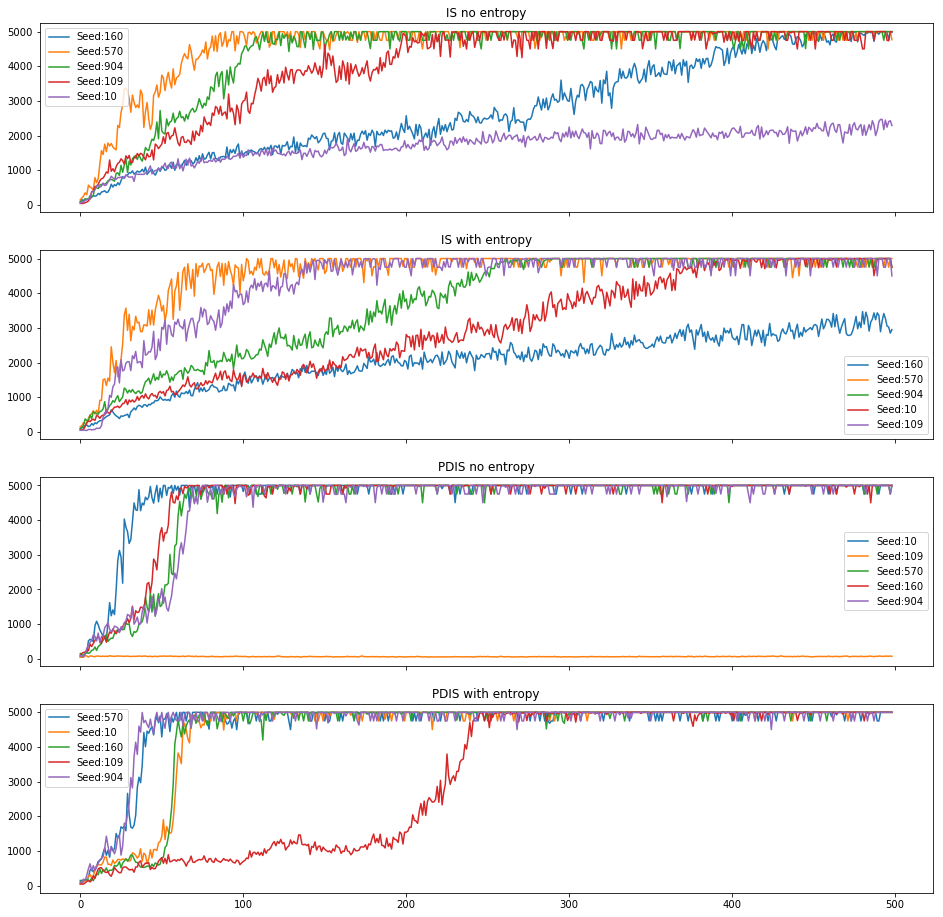

In [7]:
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(16,16), sharex=True, sharey=True)
plot_all(cp_is_20_noent, 'EpRewMean', axis[0])
axis[0].set_title('IS no entropy')
plot_all(cp_is_20_ent, 'EpRewMean', axis[1])
axis[1].set_title('IS with entropy')
plot_all(cp_pdis_20_noent, 'EpRewMean', axis[2])
axis[2].set_title('PDIS no entropy')
plot_all(cp_pdis_20_ent, 'EpRewMean', axis[3])
axis[3].set_title('PDIS with entropy')
plt.show();